# Animated cartoons of active anomaly detection

This notebook demonstrates how different anomaly detection methods selects outliers in a dataset.
We will use a 2-D toy dataset and two methods: standard Isolation Forest and active Pine Forest.

In [1]:
import io
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas  # noqa

from PIL import Image

In [2]:
from coniferest.datasets import non_anomalous_outliers, Label
from coniferest.session.oracle import create_oracle_session

In [3]:
class CartoonDrawer:
    COLORS = {Label.ANOMALY: 'red', Label.UNKNOWN: 'grey', Label.REGULAR: 'blue'}

    def __init__(self, session, title=None):
        """
        Drawing cartoons with anomaly detection.
        """
        self.title = title
        self.trajectory = np.array(list(session.known_labels.keys()))
        self.data_features = session._data
        self.data_labels = session._metadata

    def draw_cartoon(self):
        """
        Draw a animation how regressor performs.

        Returns
        -------
        List of PIL images.
        """

        data_features = self.data_features
        data_labels = self.data_labels
        COLORS = self.COLORS

        images = []
        for i in range(len(self.trajectory)):
            fig = Figure()
            canvas = FigureCanvas(fig)

            ax = fig.subplots()
            title = self.title and f'{self.title}, iteration {i}'
            ax.set(title=title, xlabel='x1', ylabel='x2')

            ax.scatter(*data_features.T, color=COLORS[Label.REGULAR], s=10)
            # We don't have trace any more
            # ax.scatter(*data_features[trace, :].T, color=COLORS[Label.ANOMALY], s=10)

            prehistory = self.trajectory[:i]
            index = data_labels[prehistory] == Label.ANOMALY
            if np.any(index):
                ax.scatter(*data_features[prehistory[index], :].T, marker='*', color=COLORS[Label.ANOMALY],
                           s=80)

            index = ~index
            if np.any(index):
                ax.scatter(*data_features[prehistory[index], :].T, marker='*', color=COLORS[Label.REGULAR],
                           s=80)

            ax.scatter(*data_features[self.trajectory[i], :].T, marker='*', color='k', s=80)

            normal_patch = mpatches.Patch(color=COLORS[Label.REGULAR], label='Regular')
            anomalous_patch = mpatches.Patch(color=COLORS[Label.ANOMALY], label='Anomalous')
            ax.legend(handles=[normal_patch, anomalous_patch], loc='lower left')

            canvas.draw()
            size = (int(canvas.renderer.width), int(canvas.renderer.height))
            s = canvas.buffer_rgba()
            image = Image.frombytes('RGBA', size, s)

            images.append(image)
            del canvas
            del fig

        return images

    def save_cartoon(self, file):
        """
        (Draw and) save a cartoon.

        Parameters
        ----------
        file
            Filename or file object to write GIF file to.

        Returns
        -------
        None
        """
        images = self.draw_cartoon()
        images[0].save(file, format='GIF',
                       save_all=True, append_images=images[1:],
                       optimize=False, duration=500, loop=0)

    def display_cartoon(self):
        """
        IPython display of the drawn GIF.

        Returns
        -------
        None
        """
        import IPython.display

        with io.BytesIO() as buffer:
            self.save_cartoon(buffer)
            return IPython.display.Image(buffer.getvalue())

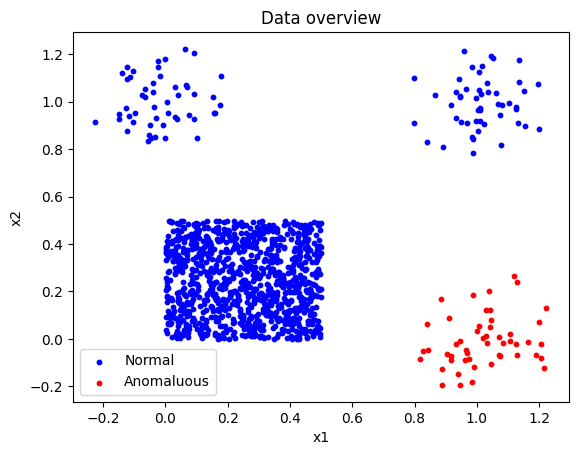

In [4]:
data, labels = non_anomalous_outliers(inliers=1000, outliers=50)

plt.figure()
plt.title('Data overview')
plt.scatter(*data[labels == 1, :].T, color='blue', s=10, label='Normal')
plt.scatter(*data[labels == -1, :].T, color='red', s=10, label='Anomaluous')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
pass

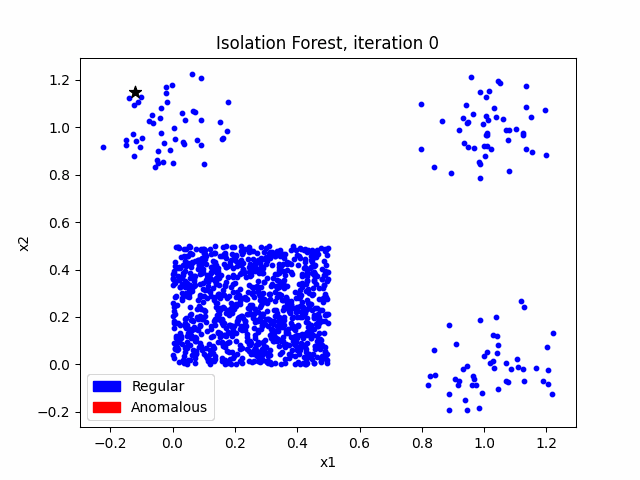

In [5]:
from coniferest.isoforest import IsolationForest

session_isoforest = create_oracle_session(
    data=data,
    labels=labels,
    model=IsolationForest(random_seed=0),
).run()

drawer = CartoonDrawer(session_isoforest, title='Isolation Forest')
drawer.display_cartoon()

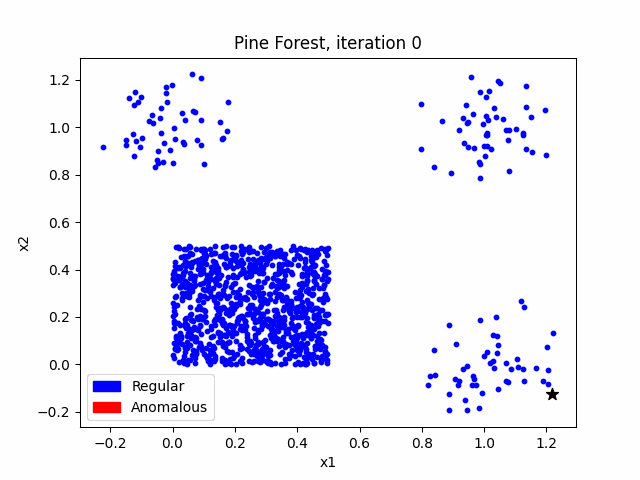

In [6]:
from coniferest.pineforest import PineForest

session_pineforest = create_oracle_session(
    data=data,
    labels=labels,
    model=PineForest(random_seed=0),
).run()

drawer = CartoonDrawer(session_pineforest, title='Pine Forest')
drawer.display_cartoon()

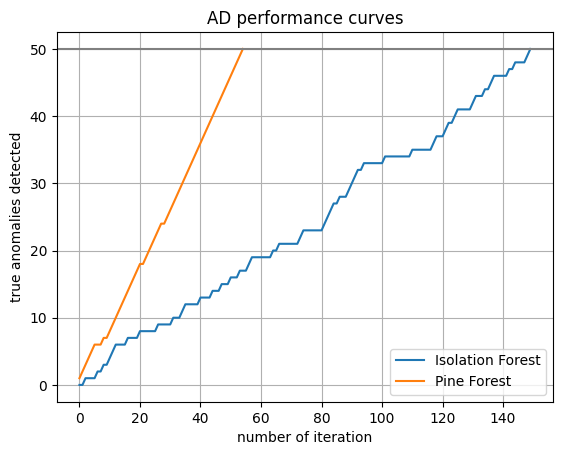

In [7]:
def perfcurve(session):
    return np.cumsum(np.fromiter(session.known_labels.values(), dtype=int) == Label.A)


plt.figure()
plt.title('AD performance curves')
plt.plot(perfcurve(session_isoforest), label='Isolation Forest')
plt.plot(perfcurve(session_pineforest), label='Pine Forest')
plt.axhline(sum(labels == Label.A), color='grey')
plt.xlabel('number of iteration')
plt.ylabel('true anomalies detected')
plt.grid()
plt.legend()
pass